In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, ARIMA
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv("planilhas/dfRegressaoDias.csv", sep=';', parse_dates=['Data'], index_col="Data")
display(df)
df.info()

print(len(df['CasosDia']))

split = int(0.7 * len(df))


,CasosDia
Data,
2020-03-15,3
2020-03-16,3
2020-03-17,3
2020-03-18,1
2020-03-19,0
...,...
2023-12-27,3
2023-12-28,6
2023-12-29,6


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1387 entries, 2020-03-15 to 2023-12-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CasosDia  1387 non-null   int64
dtypes: int64(1)
memory usage: 21.7 KB
1387


In [8]:
print(df['CasosDia'].mean())
print(df['CasosDia'].max())


67.16077865897621
878


# Média Móvel

In [10]:
janela = range(1, 20)

train = df[:split]
test = df[split:]

mseMM = []
rmseMM = []
maeMM = []
parametrosMM = []

bestMae = float('inf')


for j in range(20):

    maeCalibra = 0
    auxMae = 0
    ## CALIBRAR
    for i in janela:
        media_movel = df['CasosDia'].rolling(20).mean()

        maeCalibra = mean_squared_error(df[split:], media_movel[split:]).round(2)

        if (maeCalibra < bestMae):
            auxMae = maeCalibra
            para_MM = i



    ## TREINA
    media_movel = df['CasosDia'].rolling(para_MM).mean()

    mae = mean_absolute_error(test['CasosDia'], media_movel[split:]).round(2)
    mse = mean_squared_error(test['CasosDia'], media_movel[split:]).round(2)
    rmse = np.sqrt(mse).round(2)

    mseMM.append(mse)
    rmseMM.append(rmse)
    maeMM.append(mae)
    parametrosMM.append(para_MM)


# RESULTADOSSSS !!!!
    
parametroMaisEscolhidoMM = max(set(parametrosMM), key=parametrosMM.count)
media_maeMM = np.mean(maeMM)
media_mseMM = np.mean(mseMM)
media_rmseMM = np.mean(rmseMM)

parametrosMM.append(parametroMaisEscolhidoMM)
maeMM.append(media_maeMM)
mseMM.append(media_mseMM)
rmseMM.append(media_rmseMM)


dfMediaMovel = pd.DataFrame({
    'PARA': parametrosMM,
    'MAE': maeMM,
    'MSE': mseMM,
    'RMSE': rmseMM
})


print("!! ULTIMO VALOR (20) É A MÉDIA !!!")
display(dfMediaMovel)

dfMediaMovel.to_csv('resultadosModelos/dfMediaMovel.csv', sep = ';', index = False, encoding='UTF-8')





media_movel.to_csv('resultadosModelos/testeMediaMovel.csv', sep = ';', index = False, encoding='UTF-8')

!! ULTIMO VALOR (20) É A MÉDIA !!!


,PARA,MAE,MSE,RMSE
0,19,13.22,664.63,25.78
1,19,13.22,664.63,25.78
2,19,13.22,664.63,25.78
3,19,13.22,664.63,25.78
4,19,13.22,664.63,25.78
5,19,13.22,664.63,25.78
6,19,13.22,664.63,25.78
7,19,13.22,664.63,25.78
8,19,13.22,664.63,25.78
9,19,13.22,664.63,25.78


Data
2020-03-15         NaN
2020-03-16         NaN
2020-03-17         NaN
2020-03-18         NaN
2020-03-19         NaN
                ...   
2023-12-27    3.578947
2023-12-28    3.789474
2023-12-29    4.052632
2023-12-30    3.578947
2023-12-31    3.578947
Name: CasosDia, Length: 1387, dtype: float64

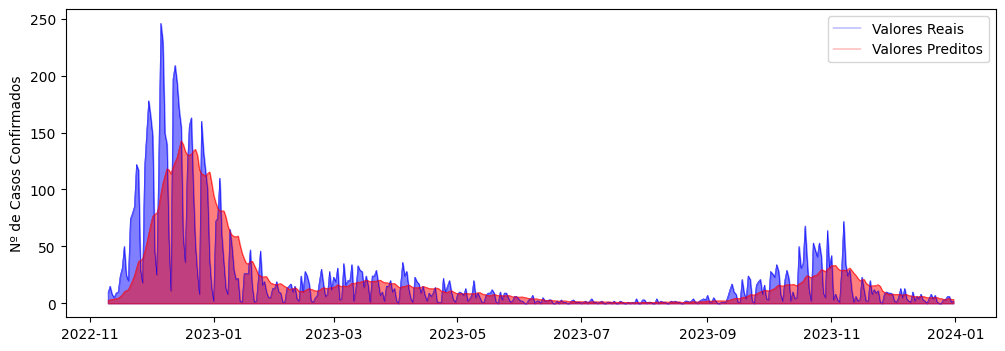

Numero de casos reais:  CasosDia    8761
dtype: int64
Numero de casos predito:  8754
Numero de casos media:  CasosDia    21.009592
dtype: float64
Numero de casos media:  20.994825192477595


In [12]:

display(media_movel)

stringGraf = 'graficos/4-'+ 'MM' + '.pdf'
plt.figure(figsize=(12, 4))
plt.plot(df[split:], label='Valores Reais', color='blue', linewidth=0.3)
plt.plot(media_movel[split:], label='Valores Preditos', color='red', linewidth=0.3)

plt.fill_between(df.index[split:], df[split:].values.flatten(), color='blue', alpha=0.5)
plt.fill_between(df.index[split:], media_movel[split:].values.flatten(), color='red', alpha=0.5)  # Pinta a área entre as linhas
plt.ylabel('Nº de Casos Confirmados')
plt.legend()
plt.savefig(stringGraf, dpi=300, bbox_inches="tight")
plt.show()

n_pred = int(media_movel[split:].sum())
print('Numero de casos reais: ', df[split:].sum())
print('Numero de casos predito: ', n_pred)

print('Numero de casos media: ', df[split:].mean())
print('Numero de casos media: ', media_movel[split:].mean())




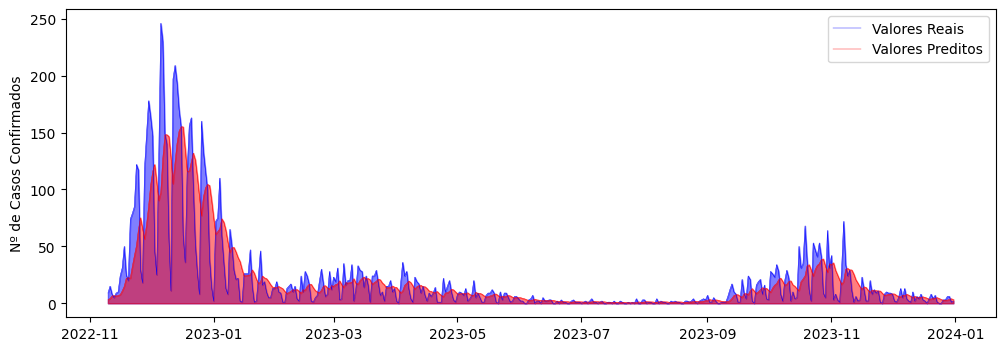

In [34]:

modelo = SimpleExpSmoothing(df).fit(smoothing_level=.2)
se = (modelo.fittedvalues)[split:]
mseCalibra = mean_squared_error(df[split:], se).round(2)



stringGraf =  'graficos/4-'+ 'SE' + '.pdf'
plt.figure(figsize=(12, 4))
plt.plot(df[split:], label='Valores Reais', color='blue', linewidth=0.3)
plt.plot(df.index[split:], se, label='Valores Preditos', color='red', linewidth=0.3)
plt.fill_between(df.index[split:], df[split:].values.flatten(), color='blue', alpha=0.5)
plt.fill_between(df.index[split:], se.values.flatten(), color='red', alpha=0.5)  # Pinta a área entre as linhas
plt.ylabel('Nº de Casos Confirmados')
plt.legend()
plt.savefig(stringGraf, dpi=300, bbox_inches="tight")
plt.show()

#n_pred = int(media_movel[split:].sum())
#print('Numero de casos reais: ', df[split:].sum())
#print('Numero de casos predito: ', n_pred)


# SUAVIZAÇÃO EXPONENCIAL - exponential-smoothing

,PARA,MAE,MSE,RMSE
0,0.9,11.6,546.73,23.38
1,0.9,11.6,546.73,23.38
2,0.9,11.6,546.73,23.38
3,0.9,11.6,546.73,23.38
4,0.9,11.6,546.73,23.38
5,0.9,11.6,546.73,23.38
6,0.9,11.6,546.73,23.38
7,0.9,11.6,546.73,23.38
8,0.9,11.6,546.73,23.38
9,0.9,11.6,546.73,23.38


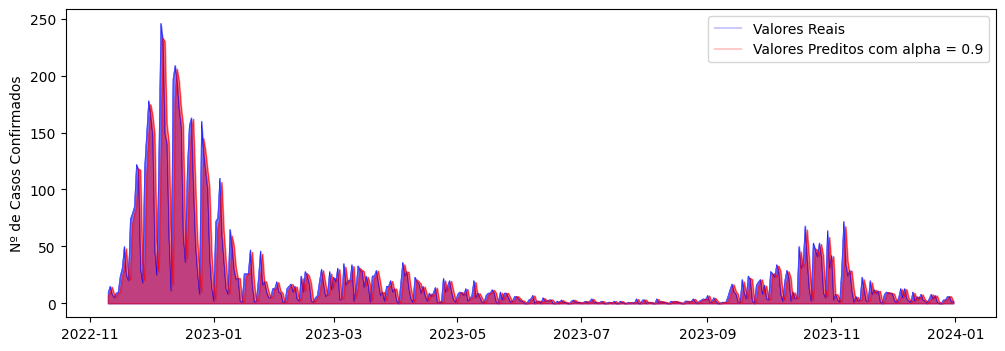

Numero de casos reais:  CasosDia    8761
dtype: int64
Numero de casos predito:  8765


In [35]:



alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8, 0.9]

mseSE = []
rmseSE = []
maeSE = []
parametrosSE = []
auxMae = 0

bestMse = float('inf')

dfSplit = df[split:]




for j in range(20):

    maeCalibra = 0

    ## CALIBRAR
    for i in alpha:
        modelo = ExponentialSmoothing(df, initialization_method="estimated").fit(smoothing_level=i, optimized=False)
        se = (modelo.fittedvalues)[split:]
        mseCalibra = mean_squared_error(df[split:], se).round(2)

        if (mseCalibra < bestMse):
            bestMse = mseCalibra
            para_SE = i




    ## TREINA
    modelo = ExponentialSmoothing(df).fit(smoothing_level=para_SE)
    se = (modelo.fittedvalues)[split:]

    mae = mean_absolute_error(dfSplit, se).round(2)
    mse = mean_squared_error(dfSplit, se).round(2)
    rmse = np.sqrt(mse).round(2)

    mseSE.append(mse)
    rmseSE.append(rmse)
    maeSE.append(mae)
    parametrosSE.append(para_SE)


# RESULTADOSSSS !!!!
    
parametroMaisEscolhidoSE = max(set(parametrosSE), key=parametrosSE.count)
media_maeSE = np.mean(maeSE)
media_mseSE = np.mean(mseSE)
media_rmseSE = np.mean(rmseSE)

parametrosSE.append(parametroMaisEscolhidoSE)
maeSE.append(media_maeSE)
mseSE.append(media_mseSE)
rmseSE.append(media_rmseSE)


dfSuaviExpo = pd.DataFrame({
    'PARA': parametrosSE,
    'MAE': maeSE,
    'MSE': mseSE,
    'RMSE': rmseSE
})

display(dfSuaviExpo)

stringGraf =  'graficos/4-'+ 'SuaviExpo' + '.pdf'
plt.figure(figsize=(12, 4))
plt.plot(df[split:], label='Valores Reais', color='blue', linewidth=0.3)
plt.plot(df.index[split:], se, label='Valores Preditos com alpha = ' + str(para_SE), color='red', linewidth=0.3)
plt.fill_between(df.index[split:], df[split:].values.flatten(), color='blue', alpha=0.5)
plt.fill_between(df.index[split:], se.values.flatten(), color='red', alpha=0.5)  # Pinta a área entre as linhas
plt.ylabel('Nº de Casos Confirmados')
plt.legend()
plt.savefig(stringGraf, dpi=300, bbox_inches="tight")
plt.show()

n_pred = int(se.sum())
print('Numero de casos reais: ', df[split:].sum())
print('Numero de casos predito: ', n_pred)






# ARIMA


In [36]:
parametros_grid = {
    'p': [0,1,2,3,4,5],
    'd': [0,1,2,3,4,5],
    'q': [1,2,3,4,5,6,7,8,9,10]
   }

'''
parametros_grid = {
    'p': [2],
    'd': [1],
    'q': [3]
   }
'''

mseARIMA = []
rmseARIMA = []
maeARIMA = []

parametroP_ARIMA = []
parametroD_ARIMA = []
parametroQ_ARIMA = []
auxMae = 0


bestMse = float('inf')

dfTeste =df[split:]

j=1

maeCalibra = 0
## CALIBRAR
for p in parametros_grid['p']:
    print('Q')
    print(j)
    for d in parametros_grid['d']:
        #print('D')
        for q in parametros_grid['q']:
            try:
                model = ARIMA(df['CasosDia'], order=(p,d,q))
                model_fit = model.fit()
                pred = model_fit.forecast(steps=len(df))
                arima = pred[split:]
                mseCalibra = mean_squared_error(dfTeste, arima).round(2)

                if (mseCalibra < bestMse):
                    bestMse = mseCalibra
                    para_p = p
                    para_d = d
                    para_q = q
            except np.linalg.LinAlgError:
                print(f"Unable to fit model with parameters p={p}, d={d}, q={q}")
                continue
    j += 1            
    

## TREINA
model = ARIMA(df['CasosDia'], order=(para_p,para_d,para_q))
model_fit = model.fit()
pred = model_fit.forecast(steps=len(df))
arima = pred[split:]

mae = mean_absolute_error(dfTeste, arima).round(2)
mse = mean_squared_error(dfTeste, arima).round(2)
rmse = np.sqrt(mse).round(2)

mseARIMA.append(mse)
rmseARIMA.append(rmse)
maeARIMA.append(mae)

parametroP_ARIMA.append(para_p)
parametroD_ARIMA.append(para_d)
parametroQ_ARIMA.append(para_q)


# RESULTADOSSSS !!!!
    
parametroMaisEscolhidoARIMA_p = max(set(parametroP_ARIMA), key=parametroP_ARIMA.count)
parametroMaisEscolhidoARIMA_d = max(set(parametroD_ARIMA), key=parametroD_ARIMA.count)
parametroMaisEscolhidoARIMA_q = max(set(parametroQ_ARIMA), key=parametroQ_ARIMA.count)

media_maeARIMA = np.mean(maeARIMA)
media_mseARIMA = np.mean(mseARIMA)
media_rmseARIMA = np.mean(rmseARIMA)


parametroP_ARIMA.append(parametroMaisEscolhidoARIMA_p)
parametroD_ARIMA.append(parametroMaisEscolhidoARIMA_d)
parametroQ_ARIMA.append(parametroMaisEscolhidoARIMA_q)

maeARIMA.append(media_maeARIMA)
mseARIMA.append(media_mseARIMA)
rmseARIMA.append(media_rmseARIMA)


dfARIMA = pd.DataFrame({
    'p': parametroP_ARIMA,
    'd': parametroD_ARIMA,
    'q': parametroQ_ARIMA,
    'MAE': maeARIMA,
    'MSE': mseARIMA,
    'RMSE': rmseARIMA
})


print("!! ULTIMO VALOR (20) É A MÉDIA !!!")
display(dfARIMA)
dfARIMA.to_csv('resultadosModelos/dfArima.csv', sep = ';', index = False, encoding='UTF-8')





Q
1
Q
2
Q
3
Q
4
Q
5
Unable to fit model with parameters p=4, d=3, q=5
Q
6
!! ULTIMO VALOR (20) É A MÉDIA !!!


,p,d,q,MAE,MSE,RMSE
0,3,0,8,22.92,1520.76,39.0
1,3,0,8,22.92,1520.76,39.0


In [37]:
import joblib


joblib.dump(arima, 'predsSalva/arima.pkl')

['predsSalva/arima.pkl']

# CHEKPOINT

In [1]:
import joblib

arima = joblib.load('predsSalva/arima.pkl')

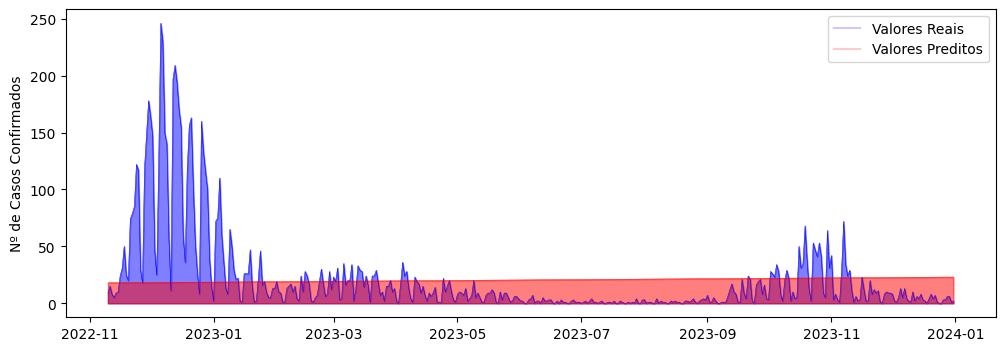

Numero de casos reais:  CasosDia    8761
dtype: int64
Numero de casos predito:  8568
Media:  20


In [4]:
stringGraf =  'graficos/4-'+ 'ARIMA' + '.pdf'
plt.figure(figsize=(12, 4))
plt.plot(df[split:], label='Valores Reais', color='blue', linewidth=0.3)
plt.plot(df.index[split:], arima, label='Valores Preditos', color='red', linewidth=0.3)
plt.fill_between(df.index[split:], df[split:].values.flatten(), color='blue', alpha=0.5)
plt.fill_between(df.index[split:], arima, color='red', alpha=0.5)  # Pinta a área entre as linhas
plt.ylabel('Nº de Casos Confirmados')
plt.legend()
plt.savefig(stringGraf, dpi=300, bbox_inches="tight")
plt.show()

n_pred = int(arima.sum())
print('Numero de casos reais: ', df[split:].sum())
print('Numero de casos predito: ', n_pred)

print('Media: ', int(arima.mean()))